# IMPORTS AND READ CSV

In [129]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

In [130]:
df_time_series = pd.read_csv('datasets/historical_demand_sum.csv', index_col='time_index')
df_time_series.index = pd.to_datetime(df_time_series.index)
df_time_series.index = df_time_series.asfreq('MS').index
df_time_series.head()

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06


<AxesSubplot: xlabel='time_index'>

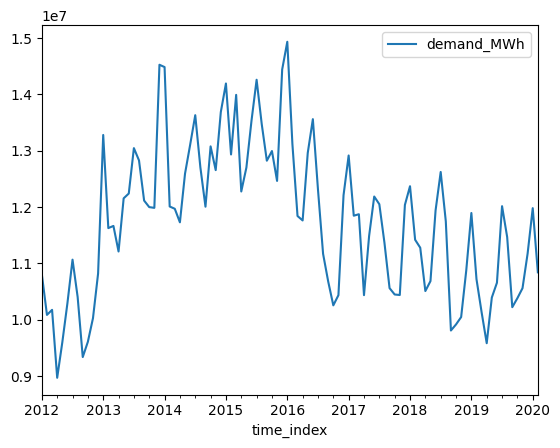

In [131]:
df_time_series.plot()

# CREATE A TIME DUMMY

In [132]:
df_time_series.index.size

98

In [133]:
df_time_series['time_dummy'] = np.arange(df_time_series.index.size)

In [134]:
df_time_series.head()

,demand_MWh,time_dummy
time_index,,
2012-01-01,1.080470e+07,0
2012-02-01,1.008555e+07,1
2012-03-01,1.017537e+07,2
2012-04-01,8.969068e+06,3
2012-05-01,9.597272e+06,4


In [135]:
X = df_time_series[['time_dummy']]
y = df_time_series['demand_MWh']

In [136]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

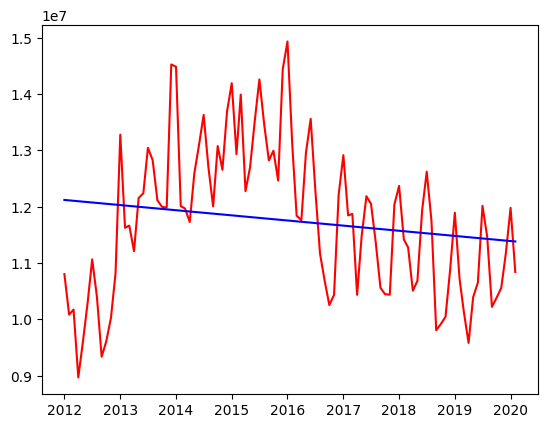

In [137]:

# ax.set_ylabel("Monthly Difference")
plt.plot(df_time_series[['demand_MWh']], c='red')
plt.plot(y_pred, c='blue')
plt.show()

# LAG FEATURE

In [138]:
df_time_series['demand_MWh_shifted'] = df_time_series['demand_MWh'].shift(1)
df_time_series.dropna(inplace=True)

In [139]:
df_time_series

,demand_MWh,time_dummy,demand_MWh_shifted
time_index,,,
2012-02-01,1.008555e+07,1,1.080470e+07
2012-03-01,1.017537e+07,2,1.008555e+07
2012-04-01,8.969068e+06,3,1.017537e+07
2012-05-01,9.597272e+06,4,8.969068e+06
2012-06-01,1.029218e+07,5,9.597272e+06
...,...,...,...
2019-10-01,1.038260e+07,93,1.022258e+07
2019-11-01,1.055948e+07,94,1.038260e+07
2019-12-01,1.117532e+07,95,1.055948e+07


In [140]:
X = df_time_series[['demand_MWh_shifted']]
y = df_time_series['demand_MWh']

In [141]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

[None,
 Text(0, 0.5, 'sales'),
 Text(0.5, 0, 'demand_MWh_shifted'),
 Text(0.5, 1.0, 'Lag Plot')]

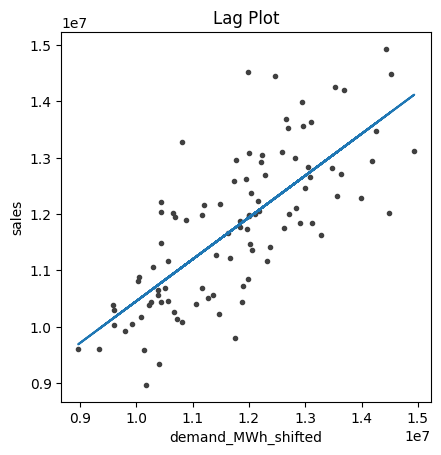

In [142]:
fig, ax = plt.subplots()
ax.plot(X['demand_MWh_shifted'], y, '.', color='0.25')
ax.plot(X['demand_MWh_shifted'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='demand_MWh_shifted', title='Lag Plot')

# TREND

In [143]:
dp = DeterministicProcess(
    index=df_time_series.index,     # dates from the training data
    constant=True,                  # dummy feature for the bias (y_intercept)
    order=1,                        # the time dummy (trend)
    drop=True,                      # drop terms if necessary to avoid collinearity
)
X = dp.in_sample()
X.index

DatetimeIndex(['2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01',
               '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
               '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
               '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
      

In [144]:
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [145]:
df_time_series['demand_MWh'].size

97

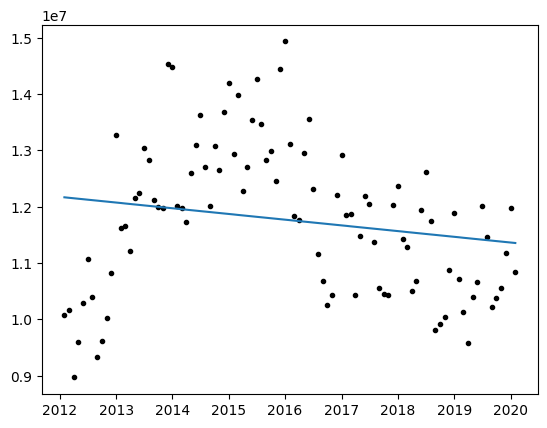

In [146]:
plt.scatter(df_time_series.index, df_time_series['demand_MWh'], c='black', marker='.')
plt.plot(y_pred)

In [147]:
X = dp.out_of_sample(30)
X.index

DatetimeIndex(['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [148]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X_to_forecast), index=X.index)

y_fore.head()

2020-03-01    1.134861e+07
2020-04-01    1.134016e+07
2020-05-01    1.133171e+07
2020-06-01    1.132326e+07
2020-07-01    1.131481e+07
Freq: MS, dtype: float64

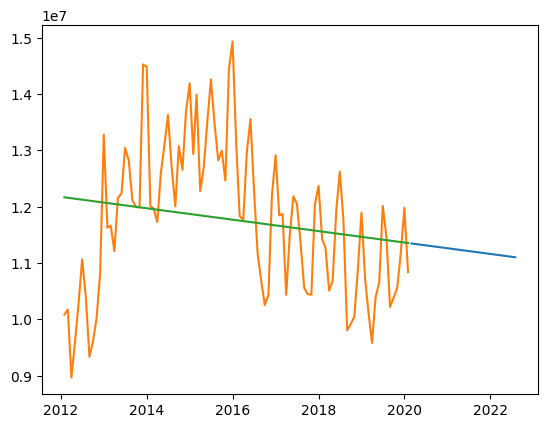

In [149]:
plt.plot(y_fore)
plt.plot(df_time_series['demand_MWh'])
plt.plot(y_pred)